In [1]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


# Original Network

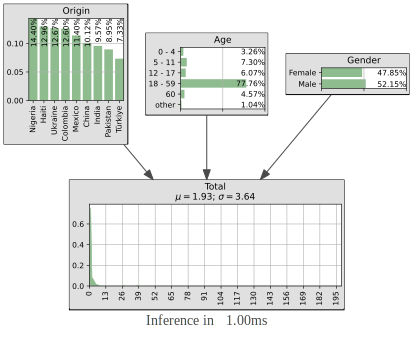

In [2]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
#df2 = df2[df2.Total >= 1000000]
countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]
genderLabel = ["Female", "Male"]
model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))

maxRange = 500

nodeList = ["Total"]
rangeNode = {"Total": 200
            }

coeff = {"Total": 1000
        }


bins={n:[i for i in range(maxRange)] for n in nodeList}

for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 100000000
    

model.addArc('Age','Total')
model.addArc('Gender','Total')
model.addArc('Origin','Total')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Gender")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]
    
for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in genderLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Gender":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, gLabel+" " +aLabel]
            temp = np.array(temp)
            
            hist = np.histogram(temp, bins["Total"])[0]
            pr=  hist/sum(hist)
            
            model.cpt("Total")[temp_dictionary]=pr
            
total_model = model
gnb.showInference(total_model, evs={},size="10")    


# Year as Child


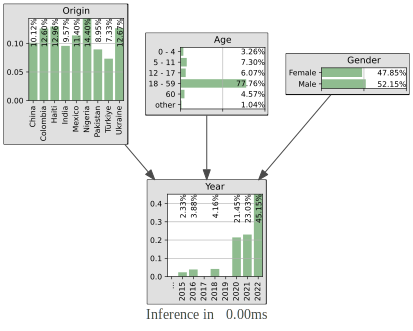

In [3]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))
yearLabel = [str(i+2001) for i in range(22)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Age','Year')
model.addArc('Gender','Year')
model.addArc('Origin','Year')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Gender")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]

for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in genderLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Gender":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, ["Year", gLabel+" " +aLabel]]
            
            if len(temp) <22:
                for year in range(2001,2023):
                    if (temp["Year"]==year).any() == False:
                        temp.loc[len(temp)]={'Year': year, gLabel+" " +aLabel: 0}
                     
                temp = temp.sort_values("Year")
                
            temp = temp.iloc[:,1]
            temp = np.array(temp)
            model.cpt("Year")[temp_dictionary]=temp

top_model = model
top_model.cpt("Year").normalizeAsCPT()
top_model.cpt("Origin").normalizeAsCPT()
top_model.cpt("Age").normalizeAsCPT()
top_model.cpt("Gender").normalizeAsCPT()

gnb.showInference(top_model, evs={},size="10")

# Year as Parent

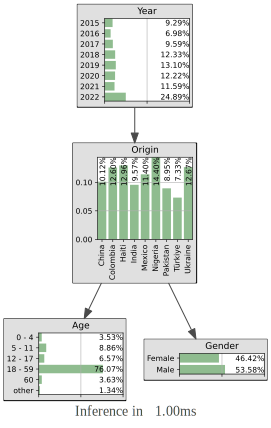

In [4]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))

df2 = df.groupby("Year").sum()
yearLabel = [str(i) for i in df2.index]
model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Gender')

model.cpt("Year")[:] = [value for value in df2.loc[:,"Total"]]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Gender")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in genderLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Gender").normalizeAsCPT()

bot_model = model
gnb.showInference(bot_model, evs={},size="10")    

# ESR Model


In [5]:
model = gum.BayesNet()

initYear = 2016
yearLabel = [str(i+initYear) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Sponsor')
model.addArc('Year','Refugee')
model.addArc('Year','Economic')

model

(pyAgrum.BayesNet<double>@000002545C422790) BN{nodes: 5, arcs: 6, domainSize: 10^7.56526, dim: 18705, mem: 147Ko 808o}

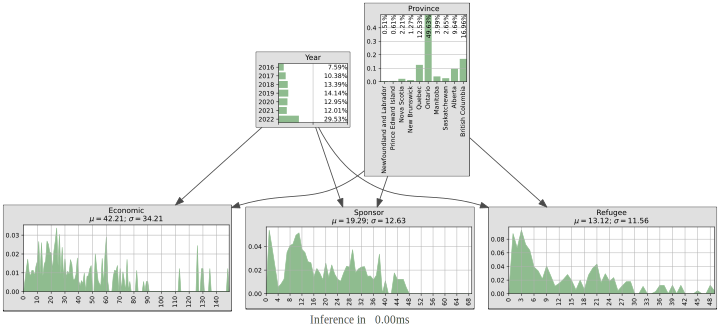

In [6]:
df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]


#dataset has different names for countries

replaceDictionary = {"China, People's Republic of":"China",
                     "Iran":"Iran (Islamic Rep. of)",
                     "Turkey":"Türkiye",
                     "Congo, Democratic Republic of the":'Dem. Rep. of the Congo',
                    "Somalia, Democratic Republic of":'Somalia',
                    "South Sudan, Republic of":'South Sudan',
                    "Sudan, Democratic Republic of":'Sudan',
                    "Syria":'Syrian Arab Rep.',
                    "Venezuela":'Venezuela (Bolivarian Republic of)'
                    }

to_canada_df = pd.read_csv("originCountry.csv").iloc[:,1:]

to_canada_df.Country.replace(replaceDictionary, inplace=True)

to_canada_df = to_canada_df[to_canada_df["Country"].isin(countryLabel)]
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]

    if index == 0:
        total_per_month = np.array(df[p].Total)
    else:
        total_per_month += np.array(df[p].Total)

total_pr = np.array(to_canada_df.iloc[:,1:].sum())


for index, cLabel in enumerate(to_canada_df.Country):
    temp_df = to_canada_df[to_canada_df["Country"]==cLabel]
    temp_df = temp_df.iloc[0,1:]
    
    for tIndex, tLabel in enumerate(temp_df):
        if tIndex % 12 == 0:
            province_data = np.zeros((len(provinceLabel)))
            
        for pIndex, pLabel in enumerate(provinceLabel):
            percent_to_province = df[pLabel].Total[tIndex]/total_per_month[tIndex]
            
            province_data[pIndex]+=(temp_df[tIndex]*percent_to_province)
            
        if (initYear+tIndex//12) >= 2023:
            continue
        model.cpt("Province")[{"Year":str(initYear+tIndex//12), "Origin":cLabel}]=province_data    
        
pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in nodeList:
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model.cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model.cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model.cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]   
        
model.cpt("Year").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Refugee").normalizeAsCPT()
model.cpt("Sponsor").normalizeAsCPT()
model.cpt("Economic").normalizeAsCPT()

esr_model = model
gnb.showInference(esr_model, evs={},size="10")


# Education Network

In [7]:
model = gum.BayesNet()

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
genderLabel = ["Female", "Male"]
educationLabel = ['0 to 8  years', 'Some high school',
       'High school graduate', 'Some postsecondary',
       'Postsecondary certificate or diploma', 'University degree']

# model.cpt("Year")[:] = [str(2015+index//12) for index in range(8)]

model.add(gum.LabelizedVariable('Gender','Gender',genderLabel)) 
# model.add(gum.LabelizedVariable('Year','Year',genderLabel)) 
model.add(gum.LabelizedVariable('Education','Education',educationLabel)) 
model.add(gum.LabelizedVariable('Province','Province',provinceLabel)) 
model.add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

model.addArc('Province','Employment Rate')
model.addArc('Gender','Employment Rate')
model.addArc('Education','Employment Rate')

model.cpt("Province").fillWith(1)
model.cpt("Gender").fillWith(1)
model.cpt("Education").fillWith(1)

model

(pyAgrum.BayesNet<double>@000002545C421050) BN{nodes: 4, arcs: 3, domainSize: 12120, dim: 12015, mem: 94Ko 848o}

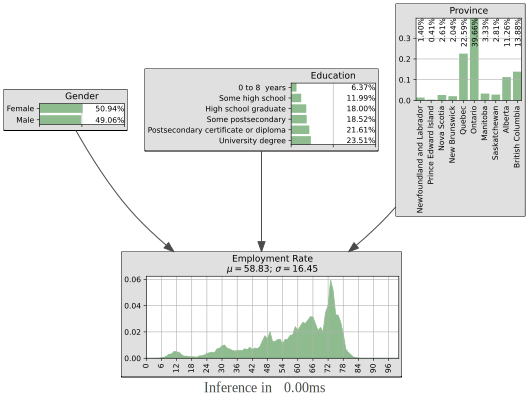

In [8]:
population_df = pd.read_csv("population_education.csv")
er_df = pd.read_csv("employment_education.csv")
# population_df.drop(["DGUID", "UOM", "UOM_ID","SCALAR_FACTOR","SCALAR_ID","AGE","VECTOR","COORDINATE"],axis=1, inplace=True)
population_df = population_df.loc[:, ["REF_DATE","GEO","Sex","Educational attainment","VALUE"]]
population_df.columns = ["Date", "Province", "Gender", "Education","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)

temp = pop_er_df
temp = temp.loc[:,"Population"] * temp.loc[:,"Employment Rate"]/100

pop_er_df = pop_er_df.join(pd.DataFrame(temp, columns=["Population ER"]))

canada_df = pop_er_df[pop_er_df["Province"]=="Canada"]

model.cpt("Gender")[:] = [canada_df.groupby("Gender").mean().Population[0], canada_df.groupby("Gender").mean().Population[1]]

avg_df =  canada_df.groupby("Education").mean()
for education in educationLabel:
    dictionary = {"Education":education}
    model.cpt("Education")[dictionary] = avg_df.loc[education, "Employment Rate"]

avg_df =  pop_er_df.groupby("Province").mean()
for province in provinceLabel:
    dictionary = {"Province":province}
    model.cpt("Province")[dictionary] = avg_df.loc[province, "Population"]/avg_df.loc["Canada", "Population"]

for province in provinceLabel:
    temp_df = pop_er_df[pop_er_df["Province"]==province] 
    for gender in genderLabel:
        for education in educationLabel:
            dictionary = {"Gender":gender, "Province":province, "Education":education}
            
            yearly_province_df = temp_df[(temp_df["Gender"]==gender+"s") & (temp_df["Education"]==education)]
            arr = np.array(yearly_province_df.loc[:,"Employment Rate"])
            arr = arr[~np.isnan(arr)]
            hist = np.histogram(arr, 101, (0,100))[0]
            data =  hist/sum(hist)
            
            model.cpt("Employment Rate")[dictionary] = data
            
model.cpt("Gender").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Education").normalizeAsCPT()
# model.cpt("Employment Rate").normalizeAsCPT()

edu_model = model            
gnb.showInference(model, evs={},size="10")

In [9]:
gnb.sideBySide(gnb.getInference(model, evs={"Gender":"Female","Province":"Alberta","Education":"0 to 8  years"},size="10"), gnb.getInference(model, evs={"Province":"Quebec"},size="10"))

# Credal Network


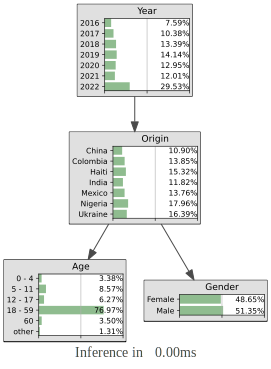

In [10]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))
yearLabel = [str(i+2001) for i in range(22)]

yearLabel = [str(i+2016) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Gender')

#populate gender/origin/age/year

df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
#     year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Gender")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in genderLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Gender").normalizeAsCPT()  

refugee_model = model
gnb.showInference(refugee_model)  


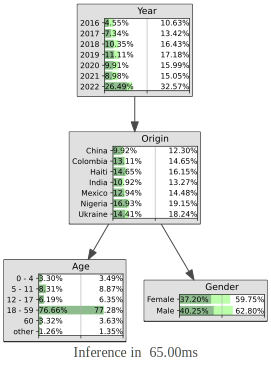

In [11]:
bn_min=gum.BayesNet(refugee_model)
bn_max=gum.BayesNet(refugee_model)
for n in refugee_model.nodes():
  x=0.4*min(refugee_model.cpt(n).min(),1-refugee_model.cpt(n).max())
  bn_min.cpt(n).translate(-x)
  bn_max.cpt(n).translate(x)

cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()
ie_mc=gum.CNMonteCarloSampling(cn)
gnb.showInference(cn,engine=ie_mc)

# cn2=gum.CredalNet(bn_min,bn_max)
# cn2.intervalToCredal()
# cn2.approximatedBinarization()
# cn2.computeBinaryCPTMinMax()

# ie_mc=gum.CNMonteCarloSampling(cn2)
# gnb.showInference(cn2,engine=ie_mc)

In [12]:
def nodevalue(n, default=-1):
    value = 0
    
    if n in edu_model.names():
        value = 0.2
        if default == 0:
            return value
        
    if n in esr_model.names():
        value = 0.7
        if default == 1:
            return value
        
    if n in refugee_model.names():
        value = 0.8
        if default == 2:
            return value
        
    if n in {"Gender","Year","Province"}:
        value = 1
        
    return value

import pyAgrum.lib.image as gumimage
gumimage.exportInference(edu_model,"bn_edu.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,0) for n in edu_model.names()})

gumimage.exportInference(esr_model,"bn_pr.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,1) for n in esr_model.names()})

gumimage.exportInference(cn,"credal_refugee.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,2) for n in refugee_model.names()})

gumimage.exportInference(refugee_model,"bn_refugee.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,2) for n in refugee_model.names()})
